In [1]:
import os
from pathlib import Path

data_dir = os.path.join(Path.home(), 'workspace/machine-learning/resource/jena-climate')
jena_path = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

# Read sequences from jena_climate csv file.
fname = open(jena_path)
data = fname.read()
fname.close()

In [2]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print('header =', header)
print('The number of lines =', len(lines))

header = ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
The number of lines = 420551


In [3]:
import numpy as np

n_sequences = len(lines)
n_labels = len(header) - 1

sequences = np.zeros((n_sequences, n_labels))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    sequences[i] = values

In [4]:
print('The shape of sequences =', sequences.shape)

The shape of sequences = (420551, 14)


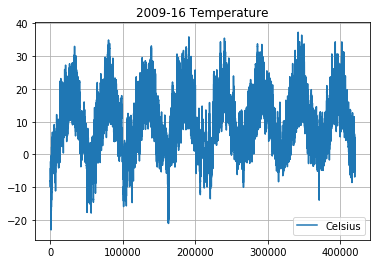

In [6]:
import matplotlib.pyplot as plt

# Seconds colum is 2009-2016 temperature data.
temperatures = sequences[:, 1]
x = np.arange(n_sequences)

plt.figure('2009-16 Temperature')
plt.title('2009-16 Temperature')
plt.plot(x, temperatures, label='Celsius')
plt.grid()
plt.legend()
plt.show()

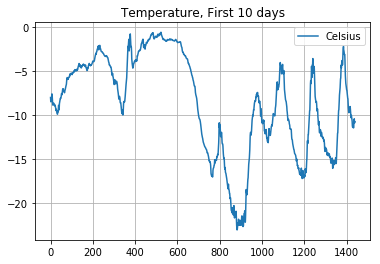

In [7]:
'''
The climate data were recorded every 10 minutes.
Plot first 10 days, 1440 samples, since observation.
'''

plt.figure('Temperature, First 10 days')
plt.title('Temperature, First 10 days')
plt.plot(x[:1440], temperatures[:1440], label='Celsius')
plt.grid()
plt.legend()
plt.show()

In [8]:
# Standardize training samples

n_train_data = 200000
train_data = sequences[:n_train_data]

mean = np.mean(train_data, axis=0)
std = np.std(train_data, axis=0)

sequences -= mean
sequences /= std

In [9]:
'''
Return a generated pair of samples and targets.
looback is interval of each samples.
steps is sampling rate.
delay is a time point of target.
'''
def sample_generator(data, lookback, delay, min_index, max_index,
                     shuffle=False, batch_size=128, step=6):
    n_samples = len(data)
    n_labels = data.shape[-1]
    if max_index is None:
        max_index = n_samples - delay - 1
    gen_idx = min_index + lookback

    while 1:
        if shuffle:
            # Choose entry indices randomly.
            entries = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            # Choose entry indices sequentialy.
            if gen_idx + batch_size >= max_index:
                gen_idx = min_index + lookback
            last = min(gen_idx + batch_size, max_index)
            entries = np.arange(gen_idx, last)
            gen_idx += len(entries)

        n_entries = len(entries)
        samples = np.zeros((n_entries, lookback // step, n_labels))
        targets = np.zeros((n_entries))
        # Choose samples from entry indice.
        for i, entry in enumerate(entries):
            indices = range(entry - lookback, entry, step)
            temperature = data[entry + delay][1]
            samples[i] = data[indices]
            targets[i] = temperature
        yield samples, targets

In [10]:
'''
looback, 1440 samples, Interval is 10 days each each samples.
step, 6 unit time, Choose 1 sample every a hour.
delay, 144 unit time, Target value is a temperature data after 24 hours.
'''
lookback = 1440
step = 6
delay = 144
batch_size = 128

n_samples = len(sequences)
n_train_data = 200000
n_val_data = 100000

train_gen = sample_generator(sequences,
                             lookback=lookback,
                             delay=delay,
                             min_index=0,
                             max_index=n_train_data,
                             shuffle=True,
                             step=step,
                             batch_size=batch_size)
val_gen = sample_generator(sequences,
                           lookback=lookback,
                           delay=delay,
                           min_index=n_train_data+1,
                           max_index=n_train_data+n_val_data,
                           step=step,
                           batch_size=batch_size)
test_gen = sample_generator(sequences,
                            lookback=lookback,
                            delay=delay,
                            min_index=n_train_data+n_val_data+1,
                            max_index=None,
                            step=step,
                            batch_size=batch_size)

In [11]:
val_steps = (n_val_data - lookback) // batch_size
test_steps = (n_samples - n_train_data - n_val_data - lookback) // batch_size

print('The number of validation batches =', val_steps)
print('The number of test batches =', test_steps)

The number of validation batches = 770
The number of test batches = 930


In [18]:
'''
Return MAEs, mean absolute error.
'''
def evaluate_naive_method(val_gen, val_steps):
    batch_maes = np.zeros((val_steps))
    for i in range(val_steps):
        samples, targets = next(val_gen)
        # Suppose that current temperature is same after 24 hours.
        preds = samples[:, -1, 1]
        batch_maes[i] = np.mean(np.abs(preds - targets))
    return batch_maes

In [20]:
val_gen_cc = sample_generator(sequences,
                              lookback=lookback,
                              delay=delay,
                              min_index=n_train_data+1,
                              max_index=n_train_data+n_val_data,
                              step=step,
                              batch_size=batch_size)

# MAE of naive model that suppose current temperature is same after 24 hours is 2.57 celsius.
# Useful deep learning model should has higher accuracy than naive model.
batch_maes = evaluate_naive_method(val_gen_cc, val_steps)
print('Navie MAE =', np.mean(batch_maes))
print('Celsius MAE =', np.mean(batch_maes)*std[1])

Navie MAE = 0.289754797477
Celsius MAE = 2.56505407873


In [23]:
# Case I : Simple densely connected network

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, sequences.shape[-1])))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=1))

model.summary()

model.compile(optimizer=optimizers.RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 8s 16ms/step - loss: 1.2308 - val_loss: 0.6553
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3930 - val_loss: 0.3267
Epoch 3/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2850 - val_loss: 0.3100
Epoch 4/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2629 - val_loss: 0.3

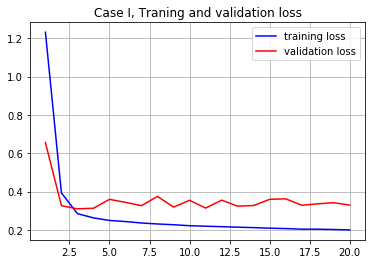

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(len(loss)) + 1

plt.figure('Case I, Traning and validation loss')
plt.title('Case I, Traning and validation loss')
plt.plot(epochs, loss, color='b', label='training loss')
plt.plot(epochs, val_loss, color='r', label='validation loss')
plt.legend()
plt.grid()
plt.show()

# Validation loss about 0.3. It is not less than naive model(0.289)!

In [14]:
'''
Case II, RNN with GRU, Gated Recurrent Unit, layer
GRU layer is similar to LSTM, long short term memory, layer.
This layer needs smaller computation than LSTM,
but has weak represetational power of features than LSTM.
'''

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.GRU(units=32, input_shape=(None, sequences.shape[-1])))
model.add(layers.Dense(units=1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 105s 211ms/step - loss: 0.3091 - val_loss: 0.2817
Epoch 2/20
500/500 [==============================] - 104s 209ms/step - loss: 0.2852 - val_loss: 0.2698
Epoch 3/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2789 - val_loss: 0.2702
Epoch 4/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2725 - val_loss: 0.2741
Epoch 5/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2662 - val_loss: 0.2620
Epoch 6/20
500/500 [==============================] - 109s 217ms/step - loss: 0.2592 - val_loss: 0.2617
Epoch 7/20
500/500 [==============================] - 108s 216ms/step - loss: 0.2546 - val_loss: 0.2713
Epoch 8/20
500/500 [==============================] - 110s 219ms/step - loss: 0.2516 - val_loss: 0.2674
Epoch 9/20
500/500 [==============================] - 106s 211ms/step - loss: 0.2464 - val_loss: 0.2763
Epoch 10/20
500/500 [==============================] - 106s 211m

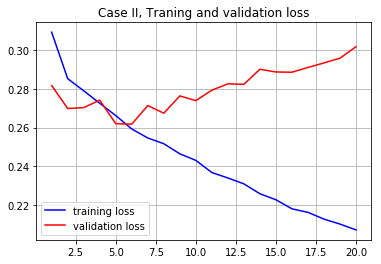

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(len(loss)) + 1

plt.figure('Case II, Traning and validation loss')
plt.title('Case II, Traning and validation loss')
plt.plot(epochs, loss, color='b', label='training loss')
plt.plot(epochs, val_loss, color='r', label='validation loss')
plt.legend()
plt.grid()
plt.show()

# Validation loss about 0.27. It is small than naive model(0.289)!

In [16]:
'''
Case III, Stacking GRU layers with dropout to regularize a model.
'''

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
# dropout parameter is ratio for input.
# recurrent_dropt parameter is ratio for each state gates of GRU.
model.add(layers.GRU(units=64,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, sequences.shape[-1])))
model.add(layers.GRU(units=64,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, sequences.shape[-1])))
model.add(layers.GRU(units=32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     input_shape=(None, sequences.shape[-1])))
model.add(layers.Dense(units=1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')

history3 = model.fit_generator(train_gen,
                               steps_per_epoch=500,
                               epochs=40,
                               validation_data=val_gen,
                               validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 381s 763ms/step - loss: 0.3406 - val_loss: 0.2968
Epoch 2/40
500/500 [==============================] - 380s 759ms/step - loss: 0.3137 - val_loss: 0.2916
Epoch 3/40
500/500 [==============================] - 380s 761ms/step - loss: 0.3049 - val_loss: 0.2799
Epoch 4/40
500/500 [==============================] - 380s 760ms/step - loss: 0.2997 - val_loss: 0.2692
Epoch 5/40
500/500 [==============================] - 380s 761ms/step - loss: 0.2959 - val_loss: 0.2673
Epoch 6/40
500/500 [==============================] - 380s 760ms/step - loss: 0.2924 - val_loss: 0.2708
Epoch 7/40
500/500 [==============================] - 374s 748ms/step - loss: 0.2895 - val_loss: 0.2700
Epoch 8/40
500/500 [==============================] - 373s 746ms/step - loss: 0.2853 - val_loss: 0.2738
Epoch 9/40
500/500 [==============================] - 373s 747ms/step - loss: 0.2826 - val_loss: 0.2718
Epoch 10/40
500/500 [==============================] - 374s 747m

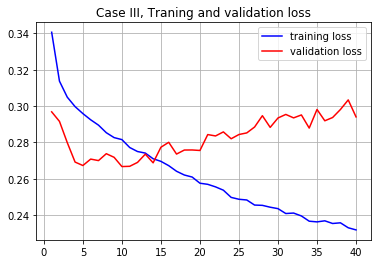

In [17]:
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = np.arange(len(loss)) + 1

plt.figure('Case III, Traning and validation loss')
plt.title('Case III, Traning and validation loss')
plt.plot(epochs, loss, color='b', label='training loss')
plt.plot(epochs, val_loss, color='r', label='validation loss')
plt.legend()
plt.grid()
plt.show()

# Validation loss about 0.265. It is small than naive model(0.289)!
# Although large amount of computations, it is no significant progress to reduce validation loss.